In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../data_utils')
from tensor_support import remove_diagonal, add_diagonal
from Sample import Sample
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()

#### Prepare to load a sample to test with

In [51]:
os.path.isfile('temp_xyz.xyz')

True

In [2]:
import os
os.path.isdir('temp_dir')

True

In [2]:
def load_dist_maps(filepath,map_location='cuda' if torch.cuda.is_available() else 'cpu'):

    try:
        data = torch.load(filepath,map_location=map_location)
    except:
        data = pd.read_pickle(filepath).unflatten()

        if type(data) != torch.Tensor:
            data = torch.tensor(data)
            
        data = data.to(map_location)
    
    if len(data.shape) == 2:
        data = data.unsqueeze(0)
    if len(data.shape) == 3:
        if data.shape[0] > 2: # Batch size is in the second channel
            data = data.unsqueeze(1)
        else: # MOST LIKELY, batch size is 1 & this dimension corresponds to channels
            data = data.unsqueeze(0)
    assert data.shape[-2] == data.shape[-1], f"Expected square matrix in final two dimensions, but received shape {data.shape}"

    if data.shape[-3] == 2:
        data = origami_transform.inverse(data)
        data = remove_diagonal(data)
    
    sample = Sample(data = data) 
    sample.unnormalize_()
    
    return add_diagonal(sample.unflatten())
    

#### Convert distance map to coordinates

In [3]:
def x_dot_y(x_norm,y_norm,x_minus_y_norm):
    # From known vector norms
    y_norm = y_norm.expand_as(x_norm)
    return (x_norm**2 + y_norm**2 - x_minus_y_norm**2) / 2

def select_new_indices(dist_from_origin,coords):
    dist_not_accounted_for = (dist_from_origin.square() - coords.square().sum(-1,keepdim=True))

    # Numerical precision occasionally causes small negative values to appear... to avoid NaN results, set those to 0!
    dist_not_accounted_for[dist_not_accounted_for<0] = 0
    dist_not_accounted_for.sqrt_()
    # Select maximum value to minimize numerical errors with division on this value later
    #return dist_not_accounted_for.max(-2,keepdim=True)
    return dist_not_accounted_for.median(-2,keepdim=True)
    
def compute_new_dimension(coords,dists,reference_indices):
    # Everything operates in-place
    if len(reference_indices) == 0:
        # Set a central bead at the origin
        idx = torch.tensor(dists.shape[-1]//2).expand_as(dists[...,:1]).to(dists.device)
        reference_indices.append(idx)

    ri = reference_indices # ease of notation
    x_norm = dists.gather(-1,ri[0]) # Distance from origin
    
    coord_value, idx = select_new_indices(x_norm,coords)
    idx = idx.expand_as(dists[...,:1])
    dim = len(ri) - 1
    y_norm = x_norm.gather(-2,idx) # Distance from origin for new reference bead
    x_minus_y_norm = dists.gather(-1,idx) # Distance between all beads and the new reference bead
    
    new_coord_values = x_dot_y(x_norm,y_norm,x_minus_y_norm)
    #print(new_coord_values)
    if dim > 0:
        selected_coord_prior_values = coords[...,:dim].gather(-2,idx.expand_as(coords[...,:dim]))
        new_coord_values-= (selected_coord_prior_values * coords[...,:dim]).sum(-1,keepdim=True) # Dot product
    new_coord_values/= coord_value
    coords[...,dim:dim+1] = new_coord_values
    
    ri.append(idx)

def dists_to_coords(dists,device=None,num_dimensions=3):

    # Use high-precision values throughout calculation, but return same dtype as provided
    # Same for device
    return_dtype = dists.dtype
    return_device = dists.device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dists = dists.double().to(device)

    # Initialize the object to hold coordinates
    coords = torch.zeros_like(dists[...,:num_dimensions])

    # Keep track of reference indices
    reference_indices = []

    for _ in range(num_dimensions): 
        compute_new_dimension(coords,dists,reference_indices)

    return coords.to(dtype=return_dtype,device=return_device)


In [4]:
def to_cuda(tensor,device=None):
    if not torch.cuda.is_available():
        return tensor
    
    if device is not None: 
        # Device passed || device type passed || device index passed
        if (device == tensor.device)\
        or (device == tensor.device.type)\
        or (device == tensor.device.index and tensor.is_cuda):
            return tensor
        if type(device) == int: # Device index passed
            return tensor.cuda(device)
        return tensor.to(device)
        
    if tensor.is_cuda:
        return tensor
    return tensor.cuda()

def coords_to_dists(coords,use_cuda=True,dtype=None):
    return_device = coords.device
    return_dtype = coords.dtype
    if use_cuda:
        coords = to_cuda(coords)
    if dtype is None: 
        dtype = torch.double
    coords = coords.to(dtype)
    
    dists = torch.cdist(coords,coords)
    i = range(dists.shape[-1])
    dists[...,i,i] = 0 # cdist sometimes provides errantly small-but-nonzero values on the diagonal

    return dists.to(dtype=return_dtype,device=return_device)
    

#### Test the dists_to_coords function with exact data

NOTE: It works, though there seems to be room for improvement on numerical accuracy

In [5]:
def generate_sample(nbeads,nsamples):

    sample = torch.empty(nsamples,nbeads,3)
    sample[:,0,:] = 0 
    for i in range(1,nbeads):
        step = torch.randn_like(sample[:,0,:])
        step/= step.square().sum(-1,keepdim=True).sqrt()
        sample[:,i,:] = sample[:,i-1,:] + step

    sample = sample.squeeze()
    if len(sample.shape) == 1:
        sample = sample.unsqueeze(0)
    
    return sample
    

Time 1: 0.016428470611572266 seconds
Time 2: 0.0015213489532470703 seconds
Time 3: 0.00023603439331054688 seconds
Time 4: 0.05285477638244629 seconds


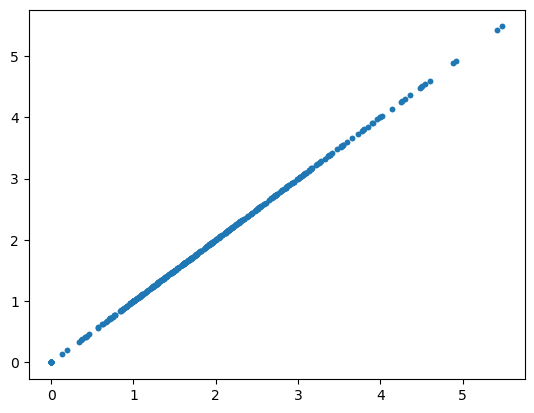

In [6]:
import time
a = generate_sample(10,10) # Use smaller batch size here... otherwise, the plotting takes an eternity
t = time.time()
dist1 = coords_to_dists(a)
t-= time.time()
print(f'Time 1: {-t} seconds')

t = time.time()
b = dists_to_coords(dist1)
t-= time.time()
print(f'Time 2: {-t} seconds')

t = time.time()
dist2 = coords_to_dists(b)
t-= time.time()
print(f'Time 3: {-t} seconds')
# Takes like 20 seconds...
t = time.time()
plt.plot(dist1.flatten().cpu(),dist2.flatten().cpu(),'.')
t-= time.time()
print(f'Time 4: {-t} seconds')

Use a larger sample to better test the quality of the functions

In [7]:
a = generate_sample(128,1000) # 1000 configurations of 128 beads

t = time.time()
dist1 = coords_to_dists(a)
t-= time.time()
print(f'Time 1: {-t} seconds')

t = time.time()
b = dists_to_coords(dist1)
t-= time.time()
print(f'Time 2: {-t} seconds')

t = time.time()
dist2 = coords_to_dists(b)
t-= time.time()
print(f'Time 3: {-t} seconds')

if torch.allclose(dist1,dist2):
    print("All close!")
else:
    print("Some NOT close!")
    diff = (dist1-dist2).abs()
    print(f'Max difference: {diff.max()}')
    i,j = torch.triu_indices(diff.shape[-1],diff.shape[-1],1)
    print(f'Max Percent Error: {100 * (diff[...,i,j]/dist1[...,i,j]).max()} %')

Time 1: 0.0168302059173584 seconds
Time 2: 0.020750761032104492 seconds
Time 3: 0.013435840606689453 seconds
Some NOT close!
Max difference: 0.0008831024169921875
Max Percent Error: 0.027429727837443352 %


#### Test with the generated samples

In [8]:
sample_dir='../../data/samples/origami_64_no_embed_reduction/s'
dists = load_dist_maps('../../data/samples/origami_64_no_embed_reduction/sample_330_3.0_0.2_120_1.pt')

In [9]:
coords = dists_to_coords(dists)
dists2 = coords_to_dists(coords)

NOTE: The unnormalization process results in a number of NaN results... and several others appear after converting to coordinates.

These issues can likely be lessened, but I haven't implemented anything for this yet. 

In [10]:
N = dists.shape[0]
print(f'Total number of samples: {N}')
print(f'Number of samples with non-finite values after unnormalizing NN-generated results: {N-dists.isfinite().all(-1).all(-1).sum()}')
print(f'Number of samples with non-finite values after converting to coordinates: {N-dists2.isfinite().all(-1).all(-1).sum()}')

Total number of samples: 1000
Number of samples with non-finite values after unnormalizing NN-generated results: 23
Number of samples with non-finite values after converting to coordinates: 34


##### Prior to any correction, results are... less than ideal

Text(0.5, 1.0, 'Distance Comparison from First Guess Coordinates')

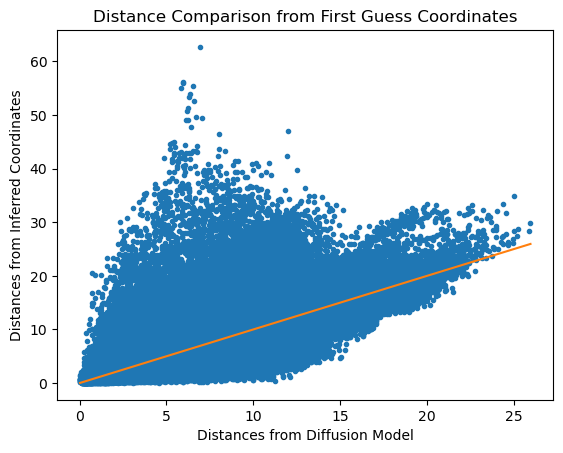

In [11]:
i = torch.where(dists.isfinite().all(-1).all(-1).flatten() & dists2.isfinite().all(-1).all(-1).flatten())[0]
j,k = torch.triu_indices(dists.shape[-1],dists.shape[-1],1)
d1 = dists[i,...][...,j,k].flatten()
d2 = dists2[i,...][...,j,k].flatten()
plt.plot(d1.cpu().numpy(),d2.cpu().numpy(),'.')
v = [
    max(d1.min().cpu(),d2.min().cpu()),
    min(d1.max().cpu(),d2.max().cpu())
]
plt.plot(v,v)
plt.xlabel('Distances from Diffusion Model')
plt.ylabel('Distances from Inferred Coordinates')
plt.title('Distance Comparison from First Guess Coordinates')

#### Correct the results

In [12]:
from tqdm.auto import tqdm

def smooth_transition_loss(
    output,
    target,
    r_c=1.0, # Transition distance from x**2 -> x**(long_scale)
    long_scale=1
):
    '''
    Reduces to smooth L1 loss if  long_scale == 1
    '''
    # Scale to ensure the two functions have the same slope at r_c
    m = 2 / long_scale
    # Shift to ensure the two functions have the same value at r_c
    b = 1 - m
    
    loss = 0
    difference = (output - target).abs() / r_c
    mask = difference < 1
    if mask.any():
        loss = loss + difference[mask].square().sum()
    mask = ~mask
    if mask.any():
        loss = loss + (m*difference[mask]**long_scale + b).sum()

    return loss
    
def loss_fcn(coords,target_dists,r_c=1.0,long_scale=1/8):
    #dists = coords_to_dists(coords,increase_precision=False)
    dists = torch.cdist(coords,coords)
    i,j = torch.triu_indices(dists.shape[-1],dists.shape[-1],1)
    return smooth_transition_loss(dists[...,i,j],target_dists[...,i,j])

def correct_coords(
    coords,
    target_dists,
    *,
    min_loss_change=1e-6,
    num_iterations=1000,
    lr=.1,
    lr_decay=0,
    weight_decay=0,
    r_c=1.0,
    long_scale=1/8
):

    return_dtype = coords.dtype
    return_device = coords.device
    coords = coords.double()
    target_dists = target_dists.double()
    if torch.cuda.is_available():
        coords = coords.cuda()
        target_dists = target_dists.cuda()

    coords.requires_grad_(True)
    
    optimizer = torch.optim.Adagrad(
        [coords],
        lr=lr,
        lr_decay=lr_decay,
        weight_decay=weight_decay
    )
    
    prior_loss = loss_fcn(coords,target_dists).detach()
    
    with tqdm(initial = 0, total = num_iterations, leave=None) as pbar:
        for i in range(num_iterations):
            optimizer.zero_grad()
            loss = loss_fcn(coords,target_dists,r_c=r_c,long_scale=long_scale)
            loss.backward()
            optimizer.step()

            loss = loss.detach()
            if i > 0 and abs(prior_loss - loss) < min_loss_change:
                print(f'Change in loss value less than tolerance: {loss - prior_loss}')
                break
            prior_loss = loss

            if i%100 == 0:
                pbar.set_description(f'loss/distance value: {loss/target_dists.numel():.4f}')
                pbar.update(100)
    
    return coords.detach().to(dtype=return_dtype,device=return_device)


Text(0, 5, '$L(x,y) = (x-y)^2$  if |x-y|<=1\n              $4|x-y|^{\\frac{1}{8}}$  otherwise')

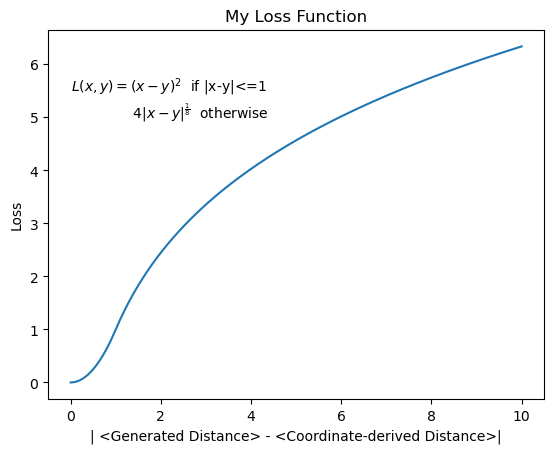

In [13]:
x = torch.arange(0,10.01,.05)
#y = torch.tensor([torch.nn.functional.smooth_l1_loss(xi,torch.tensor(0),beta=2) for xi in x])
y = torch.tensor([smooth_transition_loss(xi,torch.tensor(0),r_c=1,long_scale=1/8) for xi in x])
#y = torch.nn.functional.smooth_l1_loss(x,torch.zeros(len(x)))
plt.plot(x,y)
#y2 = torch.tensor([smooth_transition_loss(xi,torch.tensor(0),r_c=2,long_scale=1) for xi in x])
#plt.plot(x,y2)
plt.xlabel('| <Generated Distance> - <Coordinate-derived Distance>|')
plt.ylabel('Loss')
plt.title('My Loss Function')
plt.text(0,5,'$L(x,y) = (x-y)^2$  if |x-y|<=1\n              $4|x-y|^{\\frac{1}{8}}$  otherwise')

In [14]:
i = torch.where(dists.isfinite().all(-1).all(-1).flatten() & coords.isfinite().all(-1).all(-1).flatten())[0]
c = coords[i,...]
d = dists[i,...]
import os
if os.path.exists('corrected_coords_1.pt'):
    coords2 = torch.load('corrected_coords_1.pt')
else:
    coords2 = correct_coords(c,d,num_iterations=5_000,lr=.5,lr_decay=.001)
#torch.save(coords2.cpu(),'corrected_coords_1.pt')

Text(0.5, 1.0, 'Distance Comparison from Corrected Coordinates')

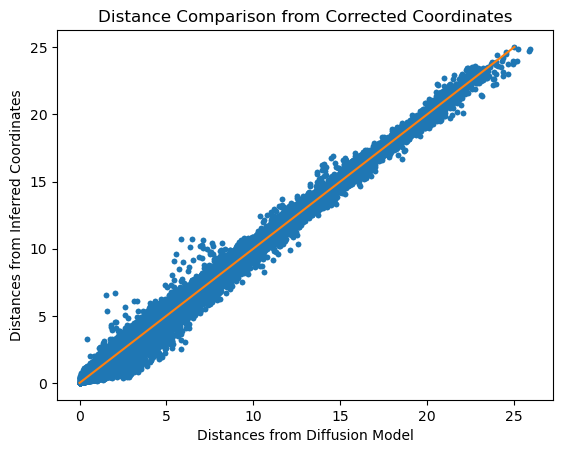

In [15]:
d2 = coords_to_dists(coords2)
j,k = torch.triu_indices(dists.shape[-1],dists.shape[-1],1)
plt.plot(d.flatten().cpu().numpy(),d2.flatten().cpu().numpy(),'.')
v = [
    max(d.min().cpu(),d2.min().cpu()),
    min(d.max().cpu(),d2.max().cpu())
]
plt.plot(v,v)
plt.xlabel('Distances from Diffusion Model')
plt.ylabel('Distances from Inferred Coordinates')
plt.title('Distance Comparison from Corrected Coordinates')

##### Single-map plots

In [16]:
def match_quality(gen_dists,target_dists,r_c=1.0,long_scale=1/8):
    N = gen_dists[0,...].numel()
    return torch.tensor([
        smooth_transition_loss(gen_dists[i,...],target_dists[i,...],r_c=r_c,long_scale=long_scale)/N for i in range(gen_dists.shape[0])
    ])

def best_match(gen_dists,target_dists=None):
    if target_dists is None: # gen_dists should be the pre-computed match_quality 
        assert gen_dists.ndim == 1, "Input should be either gen_dists & target_dists or a pre-computed match_quality."
        mq = gen_dists
    else:
        mq = match_quality(gen_dists,target_dists)

    value,index = mq.min(0)
    return value,index

def worst_match(gen_dists,target_dists=None):
    if target_dists is None: # gen_dists should be the pre-computed match_quality 
        assert gen_dists.ndim == 1, "Input should be either gen_dists & target_dists or a pre-computed match_quality."
        mq = gen_dists
    else:
        mq = match_quality(gen_dists,target_dists)

    value,index = mq.max(0)
    return value,index

def plot_dist_map(mat,*,ax=None,**kwargs):
    axis_provided = ax is not None
    if axis_provided:
        fig = ax.get_figure()
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if type(mat) == torch.Tensor:
        mat = mat.cpu().numpy()
    
    im = ax.matshow(mat,**kwargs)
    if axis_provided:
        cbar = None
    else:
        cbar = fig.colorbar(im)

    return fig, ax, im, cbar

def plot_comparison(generated_dists,corrected_dists,*,figsize=None,**kwargs):

    mats = torch.stack([generated_dists,corrected_dists],dim=0)
    if mats.ndim > 3:
        mats = mats.squeeze()
    #nrows = mats.shape[1] if mats.ndim > 3 else 1
    
    if mats.ndim == 2:
        mats.unsqueeze(-1)

    vmin = mats.min()
    vmax = mats.max()
    
    figsize = [10,4] if figsize is None else figsize

    fig = plt.figure(figsize=figsize)
    axes = []
    for i in range(mats.shape[0]):
        mat = mats[i]
        ax = fig.add_subplot(1,2,i+1)
        _,_,im,_ = plot_dist_map(mat,ax=ax,vmin=vmin,vmax=vmax)
        if i == 0:
            ax.set_title('Generated Distances: No Correction')
            ax.set_ylabel('Bin Index')
        else:
            ax.set_yticks([])
            if i == 1:
                ax.set_title('Generated Distances: With Correction')
            #else:
        ax.set_xticks([])
        axes.append(ax)
    cbar = fig.colorbar(im,label='Separation')
    fig.subplots_adjust(left=0., bottom=0., wspace=0.01,hspace=0.0)
    return fig,axes,im,cbar

def plot_best_match(generated_dists,corrected_dists):

    val, idx = best_match(generated_dists,corrected_dists)

    fig,axes,im,cbar = plot_comparison(generated_dists[idx],corrected_dists[idx])
    fig.suptitle(f'Best Match (Loss: {val:.2e}/dimension)')

    return fig,axes,im,cbar

def plot_worst_match(generated_dists,corrected_dists):

    val, idx = worst_match(generated_dists,corrected_dists)

    fig,axes,im,cbar = plot_comparison(generated_dists[idx],corrected_dists[idx])
    fig.suptitle(f'Worst Match (Loss: {val:.2e}/dimension)')

    return fig,axes,im,cbar

def plot_best_match_1D(generated_dists,corrected_dists,**kwargs):

    val, idx = best_match(generated_dists,corrected_dists)
    n = generated_dists.shape[-1]
    i,j = torch.triu_indices(n,n,1)
    
    x = generated_dists[idx][...,i,j].flatten()
    y = corrected_dists[idx][...,i,j].flatten()
    if type(x) == torch.Tensor:
        x = x.cpu().numpy()
    if type(y) == torch.Tensor:
        y = y.cpu().numpy()
    

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x,y,'.',**kwargs)
    ax.set_title('Best Match')
    ax.set_xlabel('Generated Distances: No Correction')
    ax.set_ylabel('Generated Distances: Corrected')

    return fig,ax

def plot_worst_match_1D(generated_dists,corrected_dists,**kwargs):

    val, idx = worst_match(generated_dists,corrected_dists)
    n = generated_dists.shape[-1]
    i,j = torch.triu_indices(n,n,1)
    
    x = generated_dists[idx][...,i,j].flatten()
    y = corrected_dists[idx][...,i,j].flatten()
    if type(x) == torch.Tensor:
        x = x.cpu().numpy()
    if type(y) == torch.Tensor:
        y = y.cpu().numpy()
    

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x,y,'.',**kwargs)
    ax.set_title('Worst Match')
    ax.set_xlabel('Generated Distances: No Correction')
    ax.set_ylabel('Generated Distances: Corrected')

    return fig,ax


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Best Match'}, xlabel='Generated Distances: No Correction', ylabel='Generated Distances: Corrected'>)

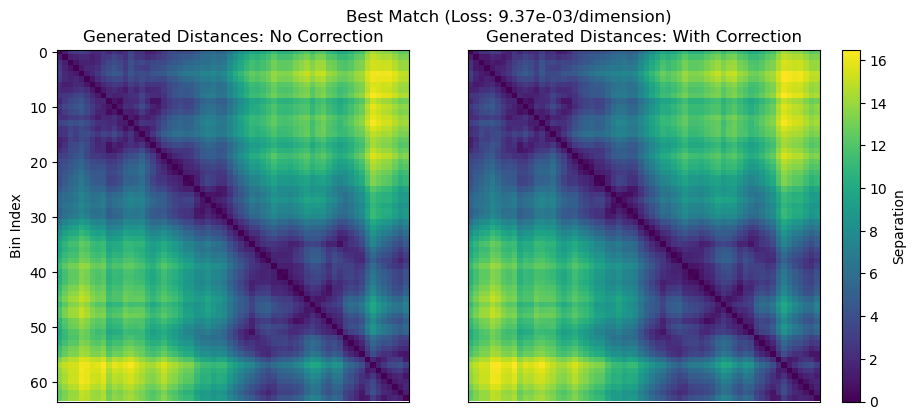

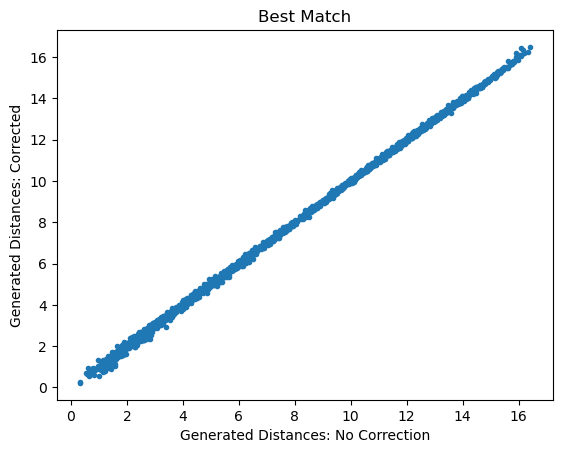

In [17]:
plot_best_match(d,d2)
plot_best_match_1D(d,d2)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Worst Match'}, xlabel='Generated Distances: No Correction', ylabel='Generated Distances: Corrected'>)

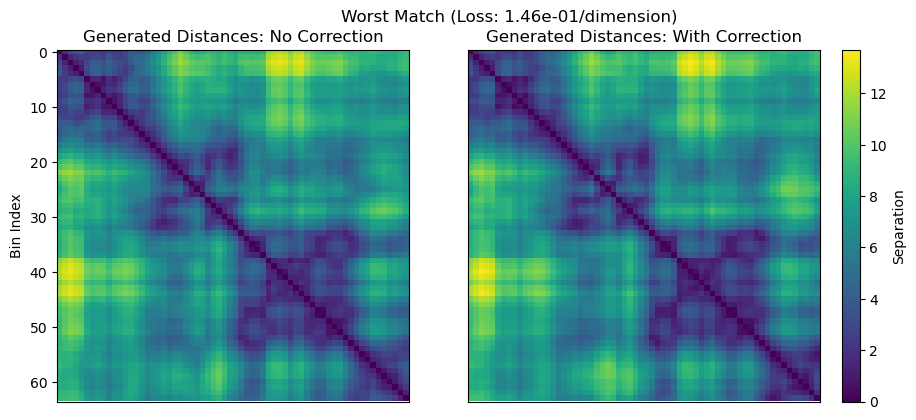

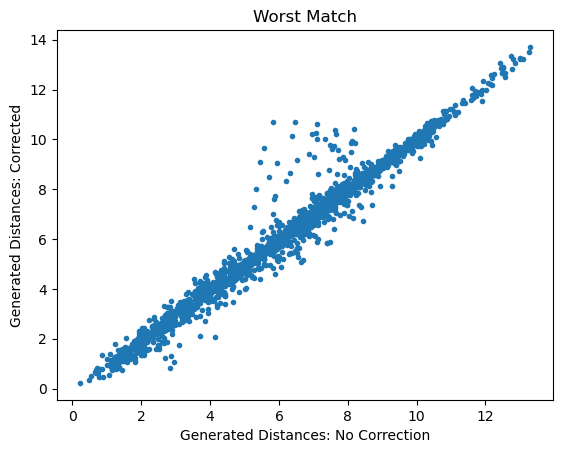

In [18]:
plot_worst_match(d,d2)
plot_worst_match_1D(d,d2)

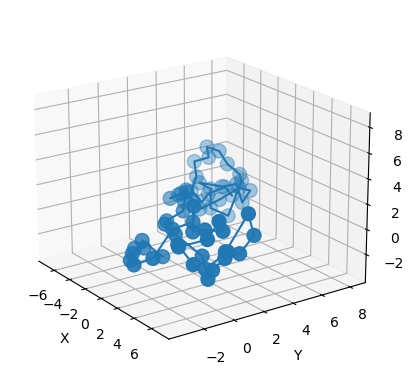

In [19]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = coords2[0,0,:,0].cpu().numpy()
y = coords2[0,0,:,1].cpu().numpy()
z = coords2[0,0,:,2].cpu().numpy()
ax.scatter(x, y, zs=z, zdir='y', label='points in (x, z)',s=100)
ax.plot(x,y,zs=z,zdir='y')

# Make legend, set axis limits and labels
'''
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
'''
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0.1)

plt.show()

In [20]:
import mdtraj as md

In [45]:
def build_psf(num_beads,filepath):

    lines = [
        'PSF CMAP CHEQ XPLOR',
        '',
        '{:>8d} !NTITLE'.format(1),
        '* HOMOPOLYMER PSF FILE',
        '',
        '',
        '{:>8d} !NATOM'.format(num_beads)
    ]

    # Atoms
    lines.extend([
        '{:>8d} {:<4s} {:<4d} {:<4s} {:<4s} {:<4s} {:<14.6}{:<14.6}{:>8d}{:14.6}'.format(
         i,     'POL', 1,     'POL', 'C',   'C',   0.0,    0.0,    0,    0.0
        ) for i in range(1,num_beads+1)
    ])

    # Bonds
    lines.extend([
        '',
        '{:>8d} !NBOND: bonds'.format(num_beads-1)
    ])
    for i in range(1,num_beads+1,4):
        line = ''
        for j in range(4):
            if i + j == num_beads:
                break
            line+= '{:>8d}{:>8d}'.format(i+j,i+j+1)
        lines.append(line)

    # Angles, dihedrals, & impropers
    lines.extend([
        '',
        '{:>8d} !NTHETA: angles'.format(0),
        '',
        '',
        '{:>8d} !NPHI: dihedrals'.format(0),
        '',
        '',
        '{:>8d} !NIMPHI: impropers'.format(0),
        ''
    ])

    with open(filepath,'w') as f:
        f.write('\n'.join(lines))

'''
def coords_to_lammpsdump_format(coords,filepath):
    coords = coords.squeeze()
    assert coords.ndim < 3
    assert coords.shape[-1] == 3
    while coords.ndim < 2:
        coords.unsqueeze(0)
    
    n_atoms = coords.shape[0]
    
    lines = [
        'Genome Data File',
        '',
        f'{n_atoms} atoms',
        f'{n_atoms-1} bonds',
        '',
        f'{n_atoms} atom types',
        '1 bond types',
        '1 angle types',
        ''
    ]
    lines.extend([
        '\t'.join([
            f'{coords[:,i].min()-1:.6f}',
            f'{coords[:,i].max()+1:.6f}',
            f'{dim}lo',
            f'{dim}hi'
        ]) for i,dim in enumerate(['x','y','z'])
    ])
    lines.extend([
        '',
        'Masses',
        ''
    ])
    lines.extend([
        '\t'.join([
            f'{i+1}',
            '1.0000'
        ]) for i in range(n_atoms)
    ])
    lines.extend([
        '',
        'Atoms',
        ''
    ])
    lines.extend([
        '\t'.join([
            f'{i+1}',
            '',
            f'{i+1}',
            '0.0000',
            f'{coords[i,0]:.6e}',
            f'{coords[i,1]:.6e}',
            f'{coords[i,2]:.6e}',
        ]) for i in range(n_atoms)
    ])
    lines.extend([
        '',
        'Bonds',
        ''
    ])
    lines.extend([
        '\t'.join([
            f'{i+1}',
            '1',
            f'{i+1}',
            f'{i+2}'
        ]) for i in range(n_atoms-1)
    ])

    with open(filepath,'w') as f:
        f.write('\n'.join(lines))
'''
def coords_to_lammpsdump_format(coords,filepath):
    coords = coords.squeeze()
    assert coords.ndim < 3
    assert coords.shape[-1] == 3
    while coords.ndim < 2:
        coords.unsqueeze(0)
    
    n_atoms = coords.shape[0]
    
    lines = [
        'Genome Data File',
        '',
        f'{n_atoms} atoms',
        f'{n_atoms-1} bonds',
        '',
        #f'{n_atoms} atom types',
        '1 atom types',
        '1 bond types',
        '1 angle types',
        '',
        '-500.000000 500.000000 xlo xhi',
        '-500.000000 500.000000 ylo yhi',
        '-500.000000 500.000000 zlo zhi',
        '',
        'Masses',
        '',
        '    1    1.000000',
        '',
        'Atoms',
        ''
    ]
    lines.extend([
        '    '.join([
            '',
            f'{i+1}',
            '',
            '1',
            '0.0000',
            f'{coords[i,0]:.6e}',
            f'{coords[i,1]:.6e}',
            f'{coords[i,2]:.6e}',
        ]) for i in range(n_atoms)
    ])
    lines.extend([
        '',
        'Bonds',
        ''
    ])
    lines.extend([
        '    '.join([
            '',
            f'{i}',
            '1',
            f'{i}',
            f'{i+1}'
        ]) for i in range(1,n_atoms)
    ])

    with open(filepath,'w') as f:
        f.write('\n'.join(lines))

def coord_to_xyz(coords,filepath):
    coords = coords.squeeze()
    assert coords.ndim < 3
    assert coords.shape[-1] == 3
    while coords.ndim < 2:
        coords.unsqueeze(0)

    n_atoms = coords.shape[0]
    lines = [
        f'{n_atoms}',
        ''
    ]
    lines.extend([
        '\t'.join([
            'C',
            f'{coords[i,0]}',
            f'{coords[i,1]}',
            f'{coords[i,2]}'
        ]) for i in range(n_atoms)
    ])
    with open(filepath,'w') as f:
        f.write('\n'.join(lines))

def coord_to_dcd(coords,dest_dir,sample_name):

    # Bring the coordinates to a standardized shape.
    assert coords.shape[-1] == 3
    if coords.ndim == 1:
        coords.unsqueeze(0)
    if coords.ndim == 2:
        coords.unsqueeze(0)
    coords = coords.flatten(-coords.ndim,-3) # Combine batch dimensions
    n_molecules = coords.shape[0]
    n_atoms = coords.shape[1]

    # Create destination directory, if necessary
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Create the psf file
    psf_filepath = dest_dir + f'/{sample_name}.psf'
    build_psf(coords.shape[-2],psf_filepath)

    # Find un-reserved temp dir for the intermediate xyz files
    temp_xyz_dir = dest_dir + '/temp/'
    i=0
    while os.path.exists(temp_xyz_dir):
        temp_xyz_dir = dest_dir + f'/temp{i}/'
        i+=1
    os.makedirs(temp_xyz_dir)

    # Create trajectories & consolidate into a single trajectory, in order
    xyz_files = [temp_xyz_dir + f'mol_{mol}.xyz' for mol in range(n_molecules)]
    for mol,fp in enumerate(xyz_files):
        coord_to_xyz(coords[mol,...],fp)

    t = md.load(xyz_files,top=psf_filepath)

    # Remove the now-unneeded xyz files
    for fp in xyz_files:
        os.remove(fp)
    os.rmdir(temp_xyz_dir)

    # Create the dcd file
    dcd_filepath = dest_dir + f'/{sample_name}.dcd'
    t.save_dcd(dcd_filepath)

    return t

In [46]:
coords_to_lammpsdump_format(coords2[0,0,...],'./temp_dir/sample1.polymer')

In [47]:
coord_to_dcd(coords2,'temp_dir','sample1')

<mdtraj.Trajectory with 955 frames, 64 atoms, 1 residues, without unitcells at 0x7f0ddc350070>

In [76]:
a = torch.rand(5,5,5)
a.flatten(-3,-2).shape

torch.Size([25, 5])

In [35]:
coord_to_psf(coords2[0,0,...],'temp.psf')
#coords_to_pdp(coords2,'temp.pdb')

t = md.load(['temp_xyz.xyz'],top='temp.psf')

In [ ]:
def to_dcd_files(coords,sample_dir):

    if os.path.exists()
    
    sample_dir
    
    

In [ ]:
for file in files:
    if not os.path.isfile(file) or file[0] == '.':
        continue

    with open(file,'r') as f:
        for line in f.readlines():
            if 'mdtraj' in line:
                print(file)
                break

In [25]:
ls

ConfigDataset.py         SequencesDataset.py        parse_sample_filenames.py
ConfigDataset_backup.py  SequencesDataset_v1.py     processing_HiC.py
Config_and_Batch.ipynb   __pycache__/               scHiCDataset.py
DataLoader.py            correct_maps.ipynb         temp.itp
DataLoader_HiC.py        corrected_coords_1.pt      temp.pdb
DataLoader_HiC1.py       deprecated/                temp_xyz.xyz
EmbeddedRegions.py       extend_mean_vectors.ipynb  tensor_support.py
HiCDataset.py            generate_embeddings.py     test.py
HiCMap.py                generate_embeddings1.py    test_DataLoader_HiC.ipynb
OrigamiTransform.py      get_sequence_data.py       test_embeddings.ipynb
Sample.py                hic/
Sample_backup.py         log_files/


In [21]:
torch.rand(5,5,5,5,5).flatten(0,-5).shape

torch.Size([5, 5, 5, 5, 5])

In [22]:
'''
header = '\n'.join([
    'loop_',
    '_atom_site.group_PDB',
    '_atom_site.id',
    '_atom_site.type_symbol',
    '_atom_site.label_atom_id',
    '_atom_site.label_alt_id',
    '_atom_site.label_comp_id',
    '_atom_site.label_asym_id',
    '_atom_site.label_entity_id',
    '_atom_site.label_seq_id',
    '_atom_site.pdbx_PDB_ins_code',
    '_atom_site.Cartn_x',
    '_atom_site.Cartn_y',
    '_atom_site.Cartn_z',
    '_atom_site.occupancy',
    '_atom_site.B_iso_or_equiv',
    '_atom_site.pdbx_formal_charge',
    '_atom_site.auth_seq_id',
    '_atom_site.auth_comp_id',
    '_atom_site.auth_asym_id',
    '_atom_site.auth_atom_id',
    '_atom_site.pdbx_PDB_model_num'
])
'''
def get_header():
    return [
        'loop_',
        '_atom_site.group_PDB',
        '_atom_site.id',
        '_atom_site.type_symbol',
        '_atom_site.label_atom_id',
        '_atom_site.label_alt_id',
        '_atom_site.label_comp_id',
        '_atom_site.label_asym_id',
        '_atom_site.label_entity_id',
        '_atom_site.label_seq_id',
        '_atom_site.pdbx_PDB_ins_code',
        '_atom_site.Cartn_x',
        '_atom_site.Cartn_y',
        '_atom_site.Cartn_z',
        '_atom_site.occupancy',
        '_atom_site.B_iso_or_equiv',
        '_atom_site.pdbx_formal_charge',
        '_atom_site.auth_seq_id',
        '_atom_site.auth_comp_id',
        '_atom_site.auth_asym_id',
        '_atom_site.auth_atom_id',
        '_atom_site.pdbx_PDB_model_num'
    ]


def coord_to_pdb_line(molecule_id,atom_number,coords):
    assert coords.numel() == 3
    coords = coords.flatten()
    
    return '\t'.join([
        f'ATOM{molecule_id}',
        f'{atom_number}',
        'N',
        'N',
        '.',
        'LYS',
        'A',
        '1',
        '7',
        '?',
        f'{coords[0]:.3f}',
        f'{coords[1]:.3f}',
        f'{coords[2]:.3f}',
        '1.00',
        '55.00',
        '?',
        '527',
        'LYS',
        'A',
        'N',
        '1'
    ])
        

def coords_to_pdp(coords):
    coords = coords.squeeze()
    while coords.ndim < 3:
        coords = coords.unsqueeze(0)
    coords = coords.flatten(0,-3)
    n_molecules = coords.shape[0]
    n_beads = coords.shape[1]

    line_list = get_header()

    for i in range(n_molecules):
        line_list.extend([
            coord_to_pdb_line(i,j+1,coords[i,j,:]) for j in range(n_beads)
        ])

    return '\n'.join(line_list)

        

'''
'ATOM   1    N N   . LYS A 1 7   ? 12.364  -13.639 8.445   1.00 54.67  ? 527 LYS A N   1',
'ATOM   2    C CA  . LYS A 1 7   ? 11.119  -12.888 8.550   1.00 49.59  ? 527 LYS A CA  1',
'ATOM   3    C C   . LYS A 1 7   ? 9.961   -13.651 7.926   1.00 44.77  ? 527 LYS A C   1',
'ATOM   4    O O   . LYS A 1 7   ? 9.055   -14.126 8.617   1.00 49.39  ? 527 LYS A O   1',
'ATOM   5    C CB  . LYS A 1 7   ? 11.255  -11.538 7.841   1.00 49.41  ? 527 LYS A CB  1',
'ATOM   6    C CG  . LYS A 1 7   ? 10.169  -10.531 8.174   1.00 53.16  ? 527 LYS A CG  1',
'ATOM   7    C CD  . LYS A 1 7   ? 10.523  -9.771  9.432   1.00 59.71  ? 527 LYS A CD  1',
'ATOM   8    C CE  . LYS A 1 7   ? 11.779  -8.947  9.195   1.00 63.60  ? 527 LYS A CE  1',
'ATOM   9    N NZ  . LYS A 1 7   ? 12.353  -8.381  10.443  1.00 64.85  ? 527 LYS A NZ  1',
'ATOM   10   N N   . ARG A 1 8   ? 10.011  -13.762 6.603   1.00 40.03  ? 528 ARG A N   1',
''';


In [23]:
pdb_file = coords_to_pdp(coords2[:2,...])

In [38]:
def coords_to_polymer_format(coords):
    coords = coords.squeeze()
    assert coords.ndim < 3
    assert coords.shape[-1] == 3
    while coords.ndim < 2:
        coords.unsqueeze(0)
    
    n_atoms = coords.shape[0]
    
    lines = [
        'Genome Data File',
        '',
        f'{n_atoms} atoms',
        f'{n_atoms-1} bonds',
        '',
        f'{n_atoms} atom types',
        '1 bond types',
        '1 angle types',
        ''
    ]
    lines.extend([
        '\t'.join([
            f'{coords[:,i].min()-1:.6f}',
            f'{coords[:,i].max()+1:.6f}',
            f'{dim}lo',
            f'{dim}hi'
        ]) for i,dim in enumerate(['x','y','x'])
    ])
    lines.extend([
        '',
        'Masses',
        ''
    ])
    lines.extend([
        '\t'.join([
            f'{i+1}',
            '1.0000'
        ]) for i in range(n_atoms)
    ])
    lines.extend([
        '',
        'Atoms',
        ''
    ])
    lines.extend([
        '\t'.join([
            f'{i+1}',
            '',
            f'{i+1}',
            '0.0000',
            f'{coords[i,0]:.6e}',
            f'{coords[i,1]:.6e}',
            f'{coords[i,2]:.6e}',
        ]) for i in range(n_atoms)
    ])
    lines.extend([
        '',
        'Bonds',
        ''
    ])
    lines.extend([
        '\t'.join([
            f'{i+1}',
            '1',
            f'{i+1}',
            f'{i+2}'
        ]) for i in range(n_atoms-1)
    ])

    return '\n'.join(lines)
    


In [39]:
def coord_to_xyz(coords,filename):
    coords = coords.squeeze()
    assert coords.ndim < 3
    assert coords.shape[-1] == 3
    while coords.ndim < 2:
        coords.unsqueeze(0)

    n_atoms = coords.shape[0]
    lines = [
        f'{n_atoms}',
        ''
    ]
    lines.extend([
        '\t'.join([
            'C',
            f'{coords[i,0]}',
            f'{coords[i,1]}',
            f'{coords[i,2]}'
        ]) for i in range(n_atoms)
    ])
    with open(filename,'w') as f:
        f.write('\n'.join(lines))

In [40]:
def coord_to_psf(coords,filename):
    coords = coords.squeeze()
    assert coords.ndim < 3
    assert coords.shape[-1] == 3
    while coords.ndim < 2:
        coords.unsqueeze(0)

    n_atoms = coords.shape[0]
    lines = [
        f'PSF',
        '',
        '\t1\t!NTITLE',
        '*  REMARKS VMD-generated NAMD/X-Plor PSF structure file',
        '',
        '\t'.join(['',f'{n_atoms}','!NATOM'])
    ]
    lines.extend([
        '\t'.join([f'{i+1}','POL','0.0',])
    ])

    lines.extend([
        '\t'.join([
            'C',
            f'{coords[i,0]}',
            f'{coords[i,1]}',
            f'{coords[i,2]}'
        ]) for i in range(n_atoms)
    ])
    with open(filename,'w') as f:
        f.write('\n'.join(lines))

In [41]:
with open('./temp_topology.polymer','w') as f:
    f.write(coords_to_polymer_format(coords[0,0,...]))

In [31]:
coord_to_xyz(coords[0,...],filename)

In [70]:
import MDAnalysis as mda
'''
with open('./temp_topology.polymer','w') as f:
    f.write(coords_to_polymer_format(coords[0,0,...]))

u = mda.Universe('./temp_topology.polymer')#,'./temp_psf_file.pdb')
'''
#filename = 'temp_xyz.xyz'
#coord_to_xyz(coords[0,...],filename)
#with open('./temp_topology.polymer','w') as f:
#    f.write(coords_to_polymer_format(coords[0,0,...]))

filename = 'temp.pdb'
with open(filename,'w') as f:
    f.write(coords_to_pdp(coords[0,0,...]))

u = mda.Universe(filename)


/home/gridsan/gschuette/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/home/gridsan/gschuette/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:304: UserWarning: Serial numbers went over 100,000.  Higher serials have been guessed
  warnings.warn("Serial numbers went over 100,000.  "
/home/gridsan/gschuette/.local/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: .
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/gridsan/gschuette/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:423: UserWarning: Invalid atom serials were present, bonds will not be parsed
  warnings.warn("Invalid atom serials were present, bonds will not"
/home/gridsan/gschuette/.local/lib/pyth

ValueError: Inconsistency in file 'temp.pdb': The number of atoms (0) in trajectory frame 0 differs from the number of atoms (64) in the corresponding topology.
Trajectories with varying numbers of atoms are currently not supported.

In [36]:
import nglview as nv

In [46]:
import MDAnalysis as mda
mda.Universe('temp_topology.polymer')

ValueError: 'POLYMER' isn't a valid topology format, nor a coordinate format
   from which a topology can be minimally inferred.
   You can use 'Universe(topology, ..., topology_format=FORMAT)'
   to explicitly specify the format and
   override automatic detection. Known FORMATs are:
   dict_keys(['PSF', 'TOP', 'PRMTOP', 'PARM7', 'PDB', 'ENT', 'XPDB', 'PQR', 'GRO', 'CRD', 'PDBQT', 'DMS', 'TPR', 'MOL2', 'DATA', 'LAMMPSDUMP', 'XYZ', 'TXYZ', 'ARC', 'GMS', 'CONFIG', 'HISTORY', 'XML', 'MMTF', 'GSD', 'MINIMAL', 'ITP', 'IN', 'FHIAIMS', 'PARMED', 'RDKIT', 'OPENMMTOPOLOGY', 'OPENMMAPP'])
   See https://docs.mdanalysis.org/documentation_pages/topology/init.html#supported-topology-formats
   For missing formats, raise an issue at 
   https://github.com/MDAnalysis/mdanalysis/issues

In [45]:
!mv temp_topology.lammpsdump temp_topology.polymer 

In [ ]:
asdf

In [67]:
filetypes = ['PSF', 'TOP', 'PRMTOP', 'PARM7', 'PDB', 'ENT', 'XPDB', 'PQR', 'GRO', 'CRD', 'PDBQT', 'DMS', 'TPR', 'MOL2', 'DATA', 
 'LAMMPSDUMP', 'XYZ', 'TXYZ', 'ARC', 'GMS', 'CONFIG', 'HISTORY', 'XML', 'MMTF', 'GSD', 'MINIMAL', 'ITP', 'IN', 'FHIAIMS', 
 'PARMED', 'RDKIT', 'OPENMMTOPOLOGY', 'OPENMMAPP']
import os
filename = 'temp.polymer'
old_filetype = 'POLYMER'
for ft in filetypes:
    #if ft == 'ITP':
    #    continue
    new_filename = filename.replace(old_filetype.lower(),ft.lower()).lower()
    os.rename(filename,new_filename)
    old_filetype = ft
    filename = new_filename

    try: 
        u = mda.Universe(filename)
        print(ft)
        break
    except:
        continue


ERROR:MDAnalysis.topology.PSF:temp.psf is not valid PSF file (header = Genome Data File
)
CRITICAL:MDAnalysis.topology.TPRparser:temp.tpr: Invalid tpr file or cannot be recognized
INFO:MDAnalysis.topology.LAMMPS:Doing Masses section
INFO:MDAnalysis.topology.LAMMPS:Doing Atoms section


ITP


In [66]:
!mv temp.openmmapp temp.polymer

In [65]:
ls

ConfigDataset.py         Sample_backup.py           log_files/
ConfigDataset_backup.py  SequencesDataset.py        parse_sample_filenames.py
Config_and_Batch.ipynb   SequencesDataset_v1.py     processing_HiC.py
DataLoader.py            __pycache__/               scHiCDataset.py
DataLoader_HiC.py        correct_maps.ipynb         temp.openmmapp
DataLoader_HiC1.py       deprecated/                temp_xyz.xyz
EmbeddedRegions.py       extend_mean_vectors.ipynb  tensor_support.py
HiCDataset.py            generate_embeddings.py     test.py
HiCMap.py                generate_embeddings1.py    test_DataLoader_HiC.ipynb
OrigamiTransform.py      get_sequence_data.py       test_embeddings.ipynb
Sample.py                hic/


In [ ]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = a[:,0]
y = a[:,1]
z = a[:,2]
ax.scatter(x, y, zs=z, zdir='y', label='points in (x, z)')

# Make legend, set axes limits and labels
'''
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
'''
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
#ax.view_init(elev=20., azim=-35, roll=0)

plt.show()

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = b[:,0].cpu()
y = b[:,1].cpu()
z = b[:,2].cpu()
ax.scatter(x, y, zs=z, zdir='y', label='points in (x, z)')

# Make legend, set axes limits and labels
'''
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
'''
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
#ax.view_init(elev=20., azim=-35, roll=0)

#plt.show()

In [ ]:
torch.cdist(b,b)[range(1,10),range(9)]

In [ ]:
plt.matshow(dist1.cpu().numpy())

In [ ]:
plt.matshow(dist2.cpu().numpy())

In [ ]:
a = torch.rand(5,5,5)
b = torch.zeros_like(a).to(bool)
b[:,0,:] = True
c = a[b].reshape(5,1,5).expand_as(a)
a==c

In [ ]:
b.gather(1,torch.zeros(5,1,5,dtype=int))#.shape

In [ ]:
b = a.shape
b[1] = 2
b

In [ ]:
a.shape[:0]

In [ ]:
torch.arange(10)[3::]

In [ ]:
torch.arange(5).repeat(2,1).shape

In [ ]:
torch.rand(2,5,10).max(1)[1]

In [ ]:
a = torch.zeros(5,5,5)
#a[:,3,:][:,1] = 1
a[...,0].scatter_(-1,torch.ones(5,5,dtype=int),torch.ones(5,5))

a

In [ ]:
import torch
torch.rand(5,5).median(1)

In [ ]:
torch.ones(5,5).ndim

In [ ]:
s1 = [2.,1] # basis vectors
s2 = [1.,3]
v = [-1.,2] # Vector we're trying to solve

v = torch.tensor(v).unsqueeze(-1)
s1 = torch.tensor(s1).unsqueeze(-1)
s2 = torch.tensor(s2).unsqueeze(-1)
S = torch.cat([s1,s2],dim=1)
print(S)

overlap = S.T @ v#( (S.T @ v).flatten() / S.T.square().sum(-1).sqrt() ).unsqueeze(-1)

torch.linalg.solve(S.T,overlap)

In [ ]:
a = generate_sample(10,3)
S = torch.tensor([
    [1.,0,0],
    [1,1,0],
    [1,1,1]
])
b = torch.linalg.solve(S,S @ a.transpose(-2,-1)).transpose(-2,-1)

In [ ]:
b-a

In [3]:
import pandas as pd 
a = pd.read_pickle('../../data/embeddings_64_after_transformer/rosetta_stone.pkl')

In [5]:
a['1']

MultiIndex([(1300000, '1',    780000),
            (1300000, '1',    800000),
            (1300000, '1',    820000),
            (1300000, '1',    840000),
            (1300000, '1',    860000),
            (1300000, '1',    880000),
            (1300000, '1',    900000),
            (1300000, '1',    920000),
            (1300000, '1',    940000),
            (1300000, '1',    960000),
            ...
            (1300000, '1', 247580000),
            (1300000, '1', 247600000),
            (1300000, '1', 247620000),
            (1300000, '1', 247640000),
            (1300000, '1', 247660000),
            (1300000, '1', 247680000),
            (1300000, '1', 247700000),
            (1300000, '1', 247720000),
            (1300000, '1', 247740000),
            (1300000, '1', 247760000)],
           names=['Region_Length', 'Chromosome', 'Genomic_Index'], length=10774)